# Rainfall variability

Code to see what happens when you alter the rainfall statistics. 

Last updated: 7 July 2020

## 1. Import model

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import sys
from datetime import datetime
from dateutil.relativedelta import *
import proplot as plot
import seaborn as sns
import scipy

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

# We need to add the module path to our system path so 
# so that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# os.chdir("../")

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *
from scripts import mkt

## 2. Import previously used outputs

In [15]:
r0 = pd.read_csv('../output/2-rainfall-variability/r0_output.csv',sep=',').drop('Unnamed: 0',axis=1)
r1 = pd.read_csv('../output/2-rainfall-variability/r25_output.csv',sep=',').drop('Unnamed: 0',axis=1)
r2 = pd.read_csv('../output/2-rainfall-variability/r50_output.csv',sep=',').drop('Unnamed: 0',axis=1)
r1930 = pd.read_csv('../output/2-rainfall-variability/r1930_output.csv',sep=',').drop('Unnamed: 0',axis=1)



## Make a table of summary statistics

Put together table of summary statistics
TODO. Re-run with 10,000 simulations

Don't wan't to include 0s in Yield calculation.

In [22]:
# Average Yield - with or without 0s?

# without 0s - need to fill in 0s with nans
# for average yield need to take non-zero numbers
r0[r0 == 0] = np.nan
r1[r1 == 0] = np.nan
r2[r2 == 0] = np.nan
r1930[r1930 == 0] = np.nan

# need to use nan mean for Yield because 0s were turned into nans
y_0, y_1, y_2, y_1930 = np.nanmean(r0.Yield),np.nanmean(r1.Yield),np.nanmean(r2.Yield),np.nanmean(r1930.Yield)

# with 0s
#y_0, y_1, y_2 = r0.Yield.mean(), r1.Yield.mean(), r2.Yield.mean()
#y_1930 = r1930.Yield.mean()

# Average RF
rf_0 = r0.RF.mean()
rf_1 = r1.RF.mean()
rf_2 = r2.RF.mean()
rf_1930 = r1930.RF.mean()

# Percent of crop failure

# Turn nans back to zeros
r0 = r0.fillna(0)
r1 = r1.fillna(0)
r2 = r2.fillna(0)
r1930 = r1930.fillna(0)

c_0 = len(r0.loc[r0['Yield'] == 0].count(axis=1))/len(r0)*100
c_1 = len(r1.loc[r1['Yield'] == 0].count(axis=1))/len(r1)*100
c_2 = len(r2.loc[r2['Yield'] == 0].count(axis=1))/len(r2)*100
c_1930 = len(r1930.loc[r1930['Yield'] == 0].count(axis=1))/len(r1930)*100

In [24]:
# eventually I will want a table with the following and so I can start to make it here
p_desc = ['Past climate','Unaltered climate','25% climate',  '50% climate']
rf = [rf_1930, rf_0, rf_1, rf_2]
y = [y_1930, y_0, y_1, y_2]
c = [c_1930, c_0, c_1, c_2]

table1 = pd.DataFrame({'Climate Description':p_desc,
                       'Average Rainfall (mm)': rf,
                       'Average Yield (t/ha)': y,
                       'Probability of Crop Failure (%)':c})

table1 = table1.round({'Average Rainfall (mm)':1,'Average Yield (t/ha)':4,
             'Probability of Crop Failure (%)':2})
#table1.to_csv('table1.csv',sep=',')

table1


,Climate Description,Average Rainfall (mm),Average Yield (t/ha),Probability of Crop Failure (%)
0,Past climate,294.2,2.0632,0.19
1,Unaltered climate,310.1,1.7606,7.86
2,25% climate,292.8,1.5818,11.52
3,50% climate,232.8,1.2215,35.90


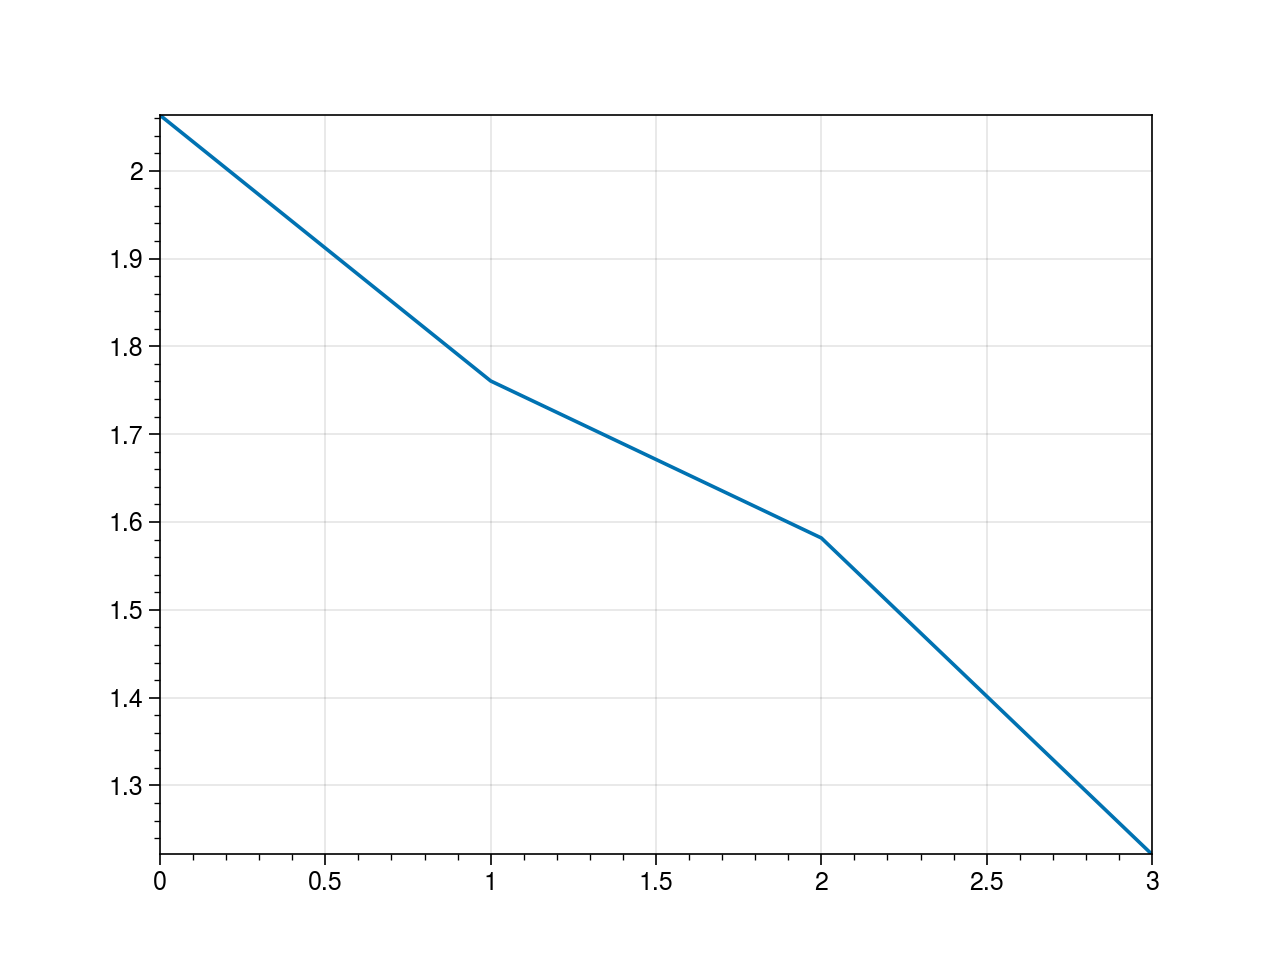

In [33]:
# Make line plot, and then make this line plot for different varieties

table1['Average Yield (t/ha)'].plot()
plt.show()
#table1['Probability of Crop Failure (%)'].plot(kind='bar')


## Translate alphas and lambdas into coefficient of variation, c.v.

See 1-rainfall-variability-stats notebook for more on this.

## 2. How do we make a more variable climate?

First idea: Increase alpha by 15%; decrease lambda by 15%

In [2]:
# normal rainfall

def run(n_sim = 1000, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg stress, total rf
    start = 60 
    end = start + lgp
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]
    
    total_rf = [df[start:end]['R'].sum() for df in output]
    #print(total_rf)

    return output, avg_stress, total_stress, total_rf

output, avg_stress, total_stress, total_rf = run()


### Change climate here

To go backwards in the climate space, we want to go from 1 and decrease this number for alpha and increase for lambda, so that is:

Alphas:
- Historic: 5.84
- Present: 9.44
- Calculate percent change
- 61.6438% increase
- 38.1356% decrease 

**For A_FAC use**: 1*(1-0.38) = 0.62

Lambdas:
- Historic: 0.459
- Present: 0.302
- 34.2048% decrease
- 51.9868% increase

**For L_FAC use**: 1*(1+.5199) = 1.5199
### Honestly not sure if the L_FAC is correct.

In [5]:
A_FAC = 0.62
L_FAC = 1.5199

In [6]:
# copying the whole climate object

#%% Climate Class Definition
from math import exp
import numpy as np
from numpy.random import exponential, uniform

default_climate = {
    'alpha_r': [10.0] * 12,
    'lambda_r': [0.25] * 12,
    'ET_max': 6.5
}

from datetime import timedelta, datetime

datetimes = np.arange(
    datetime(2018,1,1), datetime(2019,1,1), timedelta(days=1)
    ).astype(datetime)
month_value_by_day = np.array([datetime.month for datetime in datetimes])

# Should we rename this?
class Climate():

    """ Creates a years worth of daily rainfall timeseries for use in ecohydrological modeling

    Usage: climate = Climate(alpha_r, lambda_r, ET_max)

        alpha_r = average storm depth [mm]
        lambda_r = storm frequency [day^-1]
      
    Default values:
        alpha_r = 10
        lambda_r = 0.25
        t_seas = 180
        ET_max = 6.5

    Note: lambda must either be a single value (constant rainfall probability all season),
    or have length of tseas (discrete rainfall probabilities each day.

    """
    def __init__(self, alpha_r=[10.0] * 12, lambda_r=[0.25] * 12, ET_max=6.5, **kwargs):
        
       
        # Unpack the dictionary:
        self.ET_max = ET_max
        
        # Check to ensure that lambda_r is either:
        # 1. a scalar, which means we have constant climate parameters
        # 2. has length of 365, which means we have specified daily values.
        # 3. has length of 12, which means we have specified monthly values.
        if isinstance(lambda_r, (float, int)):
            if isinstance(alpha_r, (float, int)):
                # We have a constant value:
                lambda_r_list = [lambda_r] * 365
                alpha_r_list = [alpha_r] * 365
            else:
                raise ValueError("lambda_r values and alpha_r values must be same length")
        elif len(lambda_r) == 365:
            if len(alpha_r) == 365:
                lambda_r_list = lambda_r
                alpha_r_list = alpha_r
            else:
                raise ValueError("lambda_r values and alpha_r values must be same length")
        elif len(lambda_r) == 12:
            if len(alpha_r) == 12:
                # We have monthly values (remember that python is zero-indexed)
                lambda_r_list = np.array(
                    [lambda_r[month_value-1] for month_value in month_value_by_day]
                    )
                alpha_r_list = np.array(
                    [alpha_r[month_value-1] for month_value in month_value_by_day]
                    )
            else:
                raise ValueError("lambda_r values and alpha_r values must be same length")
        else:
            raise ValueError(
                "lambda_r & alpha_r values should be a constant, have length of t_sim, or have length of 12"
            )
      
        # Set the rainfall parameters for this instance
        self.alpha_r = alpha_r_list*A_FAC
        self.lambda_r = lambda_r_list*L_FAC
        
        # Use the static method, generate, to create this instance's rainfall.
        self.rainfall = self.generate(self.alpha_r, self.lambda_r)

        # Assign any other passed parameters (e.g. site, etc...)
        for key, value in kwargs.items():
            self.key = value


    def calc_E(self, s, q=1.5, LAI=None, sh=None): 
        """ Determines the daily evaporation as a function of relative soil moisture

        Usage: calc_E(s)

            TODO: Update parameters.

            s = relative soil moisture [0-1]
            E_max_p = E_max * exp(-k * LAI)
            E = E_max * [(s-sh)/(1-sh)]^q

        """
        if LAI == None:
            raise ValueError("Climate calc_E expects LAI that's not None.")

        k = 0.5
        E_max_p = self.ET_max*exp(-k*LAI) 
        if s >= sh:
            return pow((s-sh)/(1-sh), q)*E_max_p
        else:
            return 0

    @staticmethod # Static methods can be called without instancing the class.
    def generate(alpha_r, lambda_r, t_sim=365, doy_start=1):
        """ Makes a time series of rainfall based on parameters

        Usage:
            generate(alpha_r, lambda_r, t_seas)

            alpha_r = average storm depth [mm]
            lambda_r = storm frequency [day^-1]
            t_seas = lenght of growing season [days]

        Note: lambda must either be a single value (constant rainfall probability all season),
        or have length of tseas (discrete rainfall probabilities each day.

        """
        # Force doy to be in [1,365]:
        doys = np.arange(doy_start, doy_start + t_sim)
        while (doys - 365 > 0).any() == True:
            doys = doys - 365 * ((doys - 365) > 0)

        amounts = [exponential(scale=alpha_r[doy-1], size=1)[0] for doy in doys]
        rain_days = [(uniform(low=0, high=1, size=1) <= lambda_r[doy-1] ).astype(int) for doy in doys]
        return np.multiply(amounts, [v[0] for v in rain_days])



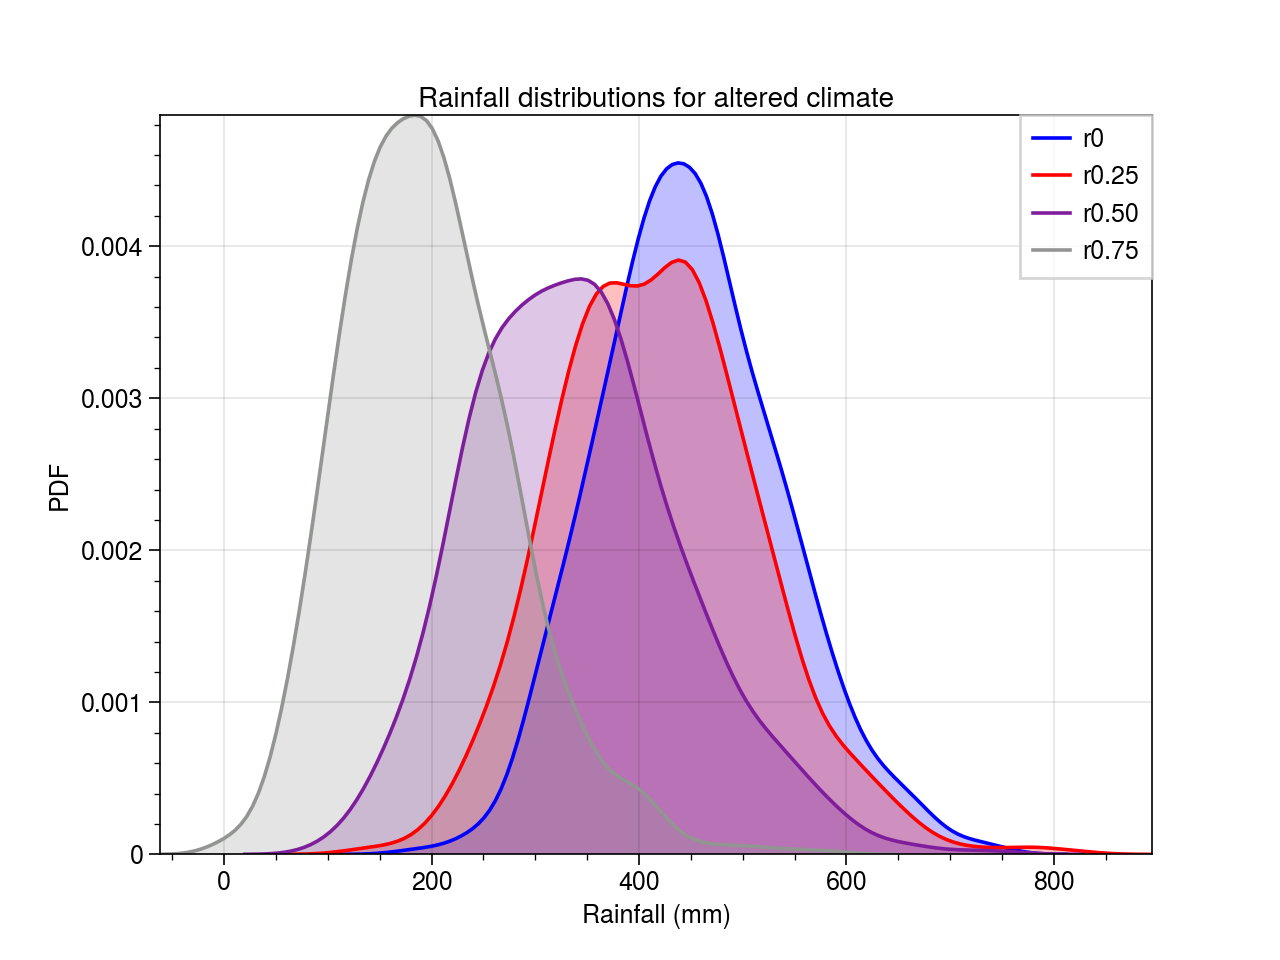

In [50]:
# altered rainfall

# used this to save rainfall ouputs
# can re-import them to make the plot
#output_c, avg_stress_c, total_stress_c, total_rf_c = run()

# Let's get a PDF of the rainfall

# sns.kdeplot(total_rf, shade=True, color="blue", label='r0')
# sns.kdeplot(total_rf_a, shade=True, color="red", label='r0.25')
# sns.kdeplot(total_rf_b, shade=True, color="purple", label='r0.50')
# sns.kdeplot(total_rf_c, shade=True, color="gray", label='r0.75')
# plt.xlabel('Rainfall (mm)')
# plt.ylabel('PDF')
# plt.title('Rainfall distributions for altered climate')
# plt.legend()

#plt.savefig('../output/2-rainfall-variability/rf_PDFs.png')


In [45]:
# let's get the summary stats of all these vars
# total_rf

# df = pd.DataFrame([total_rf, total_rf_a, total_rf_b, total_rf_c], index =['r0','r0.25','r0.5','r0.75']).T
# stats = df.describe()

# # add some additional stats

# stats.loc['IQR'] = stats.loc['75%'] - stats.loc['25%'] # appending interquartile range instead of recalculating it
# stats = stats.append(df.reindex(stats.columns, axis=1).agg(['skew', 'mad', 'kurt']))
# stats

,r0,r0.25,r0.5,r0.75
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,450.182010,418.317863,340.059429,199.018732
std,87.648357,96.543664,100.940270,81.386825
min,182.059103,130.901820,99.548389,24.152438
25%,390.122764,350.733460,266.581714,141.314219
50%,445.167861,415.869761,334.339427,189.457034
75%,507.013442,480.026096,401.278896,243.531928
max,742.857690,818.188896,748.334405,569.738822
IQR,116.890678,129.292636,134.697182,102.217709
skew,0.288355,0.359526,0.472586,0.750342


In [51]:
# cool, let's output these variables and save the summary stats

# df.to_csv('../output/2-rainfall-variability/rainfall_ts.csv',sep=',')
# stats.to_csv('../output/2-rainfall-variability/summary_stats.csv',sep=',')


## Now make cultivars figure

In [7]:
# Have to re-create the run_model function so that in crop.calc_dstress it uses my evolved_calc_yield function

def run_model(n_sim = 500, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period because model starts 21 days before planting
    start = 60 
    end = start + lgp

    # dont need this but helpful for debugging
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    o = output
    
    # Part 6. Output the dynamic stress and yield values
    x = [crop.calc_dstress(s=df.s, stress=df.stress, Y_MAX = evolved_calc_yield(i, m, b)) for df in o] # I have no clue whether this will work
    
    return x, total_rf


0.3905396783804279
m 0.01875098888679605
b 0.29946317573930376


<Figure size 500x400 with 0 Axes>

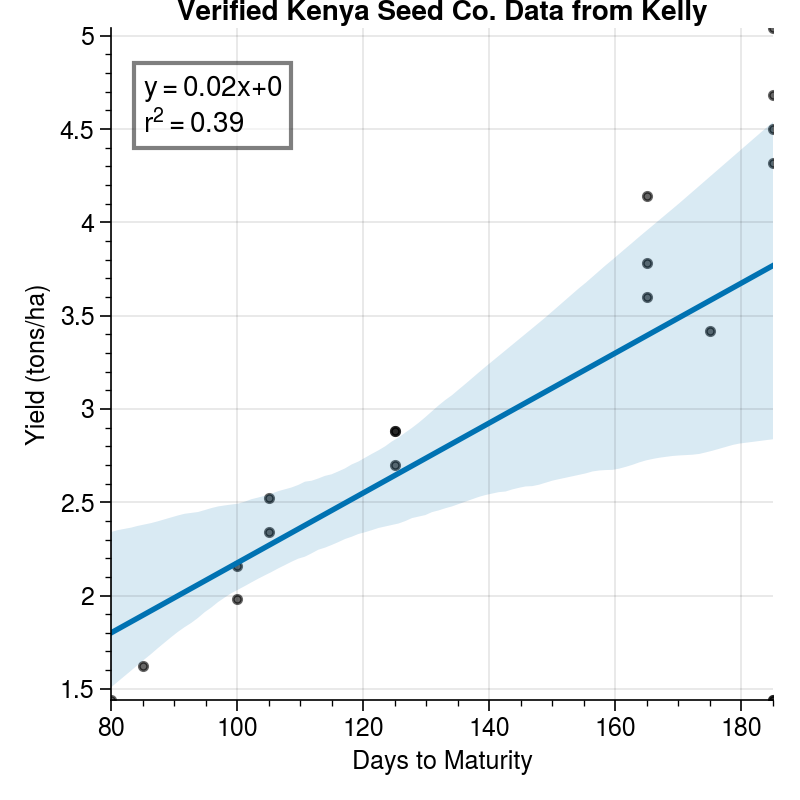

In [8]:
# verified using Kenya Seed Co. - https://web.archive.org/web/20190819125927/http://kenyaseed.com/gallery/maize/
verified_hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_verified.csv')
verified_hybrid_data

# convert to metric tons
verified_hybrid_data['yield_metric_tons'] = verified_hybrid_data.verified_yield_kg_acre/1000
verified_hybrid_data

p, m, b = plot_lin_regression(verified_hybrid_data.verified_days_to_maturity, verified_hybrid_data.yield_metric_tons, 
                              'verified_days_to_maturity', 'yield_metric_tons', verified_hybrid_data, 
                              85, 4.8, 'Days to Maturity', 'Yield (tons/ha)', 
                              'Verified Kenya Seed Co. Data from Kelly', positive=True)

In [9]:
def evolved_calc_yield(dtm=None, m = None, b = None):
    yield_kg_ha = m*dtm + b
    
    if dtm > 175:
        raise ValueError("days to maturity, {dtm} is larger than 175".format(
                dtm=dtm))
    if dtm < 68:
        raise ValueError("days to maturity, {dtm} is less than 68".format(
                dtm=dtm))
    
    return yield_kg_ha

evolved_calc_yield(100, m, b)
evolved_calc_yield(175,m,b)

3.5808862309286122

In [10]:
# Now I have to re-run the simulations using the max yields from this relationship

varieties = np.arange(75,180,5) # 21 is a better number to work with because it divides by three
len(varieties)

result = []

for i in varieties:
    # note: bumping up to 200 sims per cultivar type takes several minutes to run
    # whereas 100 sims where varieties = np.arange(70,200,5) takes less than a minute.
    data, rf = run_model(n_sim = 100, station = 'OL JOGI FARM', texture = 'clay loam', lgp=i, pd_sim=60)
    df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
    df['RF'] = rf
    df['Cultivar'] = i
    result.append(df)
    
result = pd.concat(result)
result

,AvgStress,DynamicStress,Yield,RF,Cultivar
0,0.045328,0.066052,1.593116,185.505068,75
1,0.140045,0.285702,1.218440,202.465331,75
2,0.212101,0.321440,1.157479,182.576412,75
3,0.214250,0.408003,1.009822,163.351103,75
4,0.105635,0.115465,1.508828,214.641452,75
...,...,...,...,...,...
95,0.218188,0.324293,2.419630,438.047884,175
96,0.197251,0.176153,2.950103,404.711587,175
97,0.192519,0.184083,2.921704,467.563562,175
98,0.222742,0.157911,3.015426,363.496138,175


In [11]:
# Add categorical values for early, medium and late maturing
# There is probably a way more efficient way to do this

def category(x):
    if x < 110:
        return "Early (< 105 d)"
    if 110 <= x <= 140:
        return "Medium (110 - 140 d)"
    else:
        return "Late (145 + d)"
    
for row in result.Cultivar:
    result['Category'] = result.Cultivar.apply(lambda x: category(x))

result.Category.value_counts()

result_safe = result


In [12]:
result

,AvgStress,DynamicStress,Yield,RF,Cultivar,Category
0,0.045328,0.066052,1.593116,185.505068,75,Early (< 105 d)
1,0.140045,0.285702,1.218440,202.465331,75,Early (< 105 d)
2,0.212101,0.321440,1.157479,182.576412,75,Early (< 105 d)
3,0.214250,0.408003,1.009822,163.351103,75,Early (< 105 d)
4,0.105635,0.115465,1.508828,214.641452,75,Early (< 105 d)
...,...,...,...,...,...,...
95,0.218188,0.324293,2.419630,438.047884,175,Late (145 + d)
96,0.197251,0.176153,2.950103,404.711587,175,Late (145 + d)
97,0.192519,0.184083,2.921704,467.563562,175,Late (145 + d)
98,0.222742,0.157911,3.015426,363.496138,175,Late (145 + d)


In [13]:
# Save the results I got to csvs

#result_safe.to_csv('../output/2-rainfall-variability/r0_output.csv',sep=',')
#result025.to_csv('../output/2-rainfall-variability/r25_output.csv',sep=',')
#result05.to_csv('../output/2-rainfall-variability/r50_output.csv',sep=',')
#result_safe.to_csv('../output/2-rainfall-variability/r1930_output.csv',sep=',')

## Make three (seperate) plots

Would want to re-import the results data before running this. 
Also might want the subplots figure to work with one uniform colorbar between all of them; potentially not a trivial task. 

(0.0, 700.0)

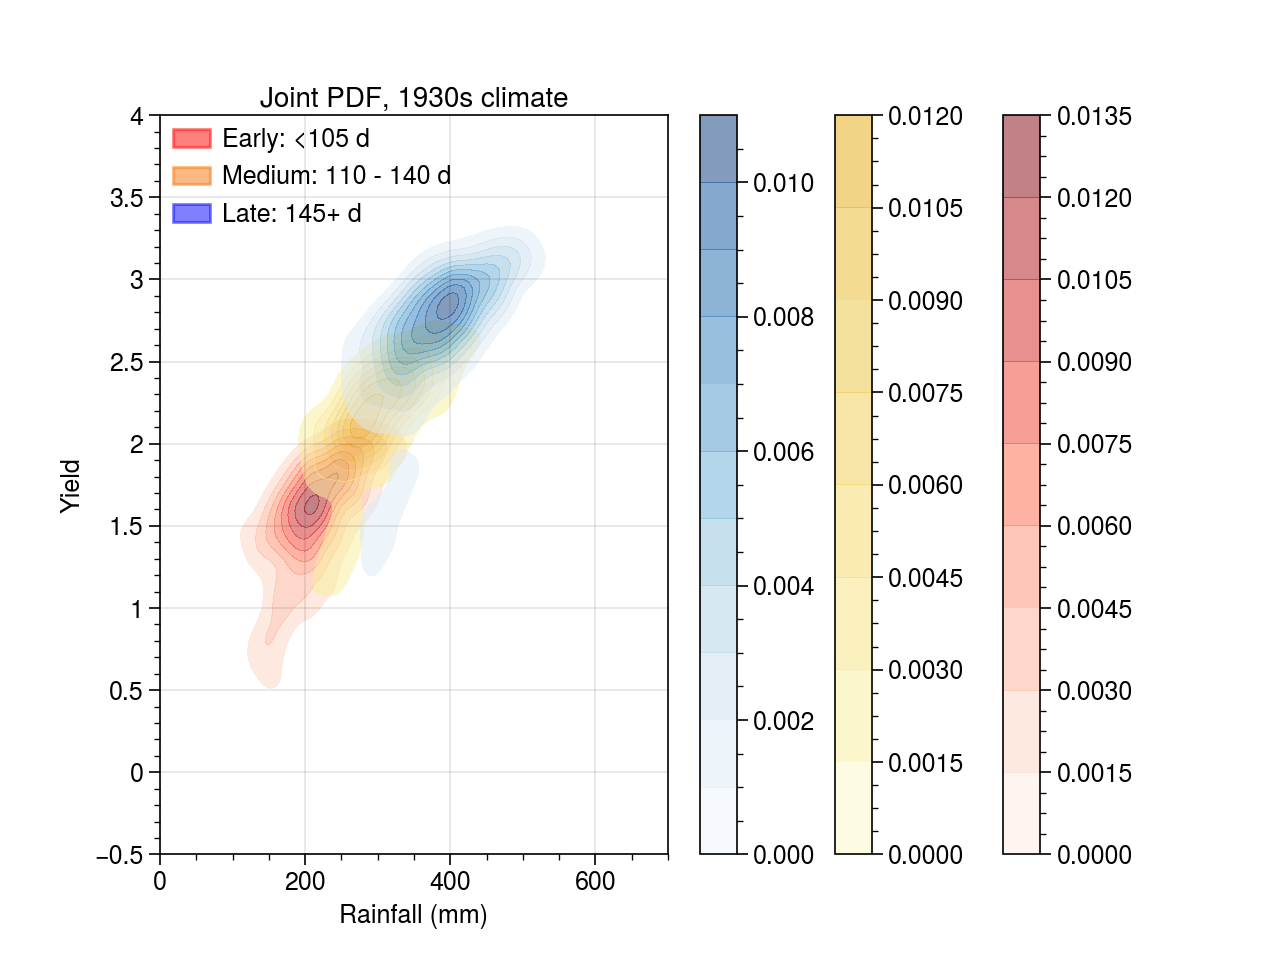

In [14]:
# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

#plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
result=result_safe

########## Plot 1

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Set up the figure
f, axs = plt.subplots() #3, figsize=(6,10), sharex=True, sharey=True) # figsize=(15, 15)
#ax.set_aspect("equal")

# Draw the two density plots
axs = sns.kdeplot(early.RF, early.Yield, alpha=0.5,
                 cmap="reds", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
                 cmap="orange1", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
                 cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
plt.title('Joint PDF, 1930s climate')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(-.5,4)
plt.xlim(0,700)

(0.0, 700.0)

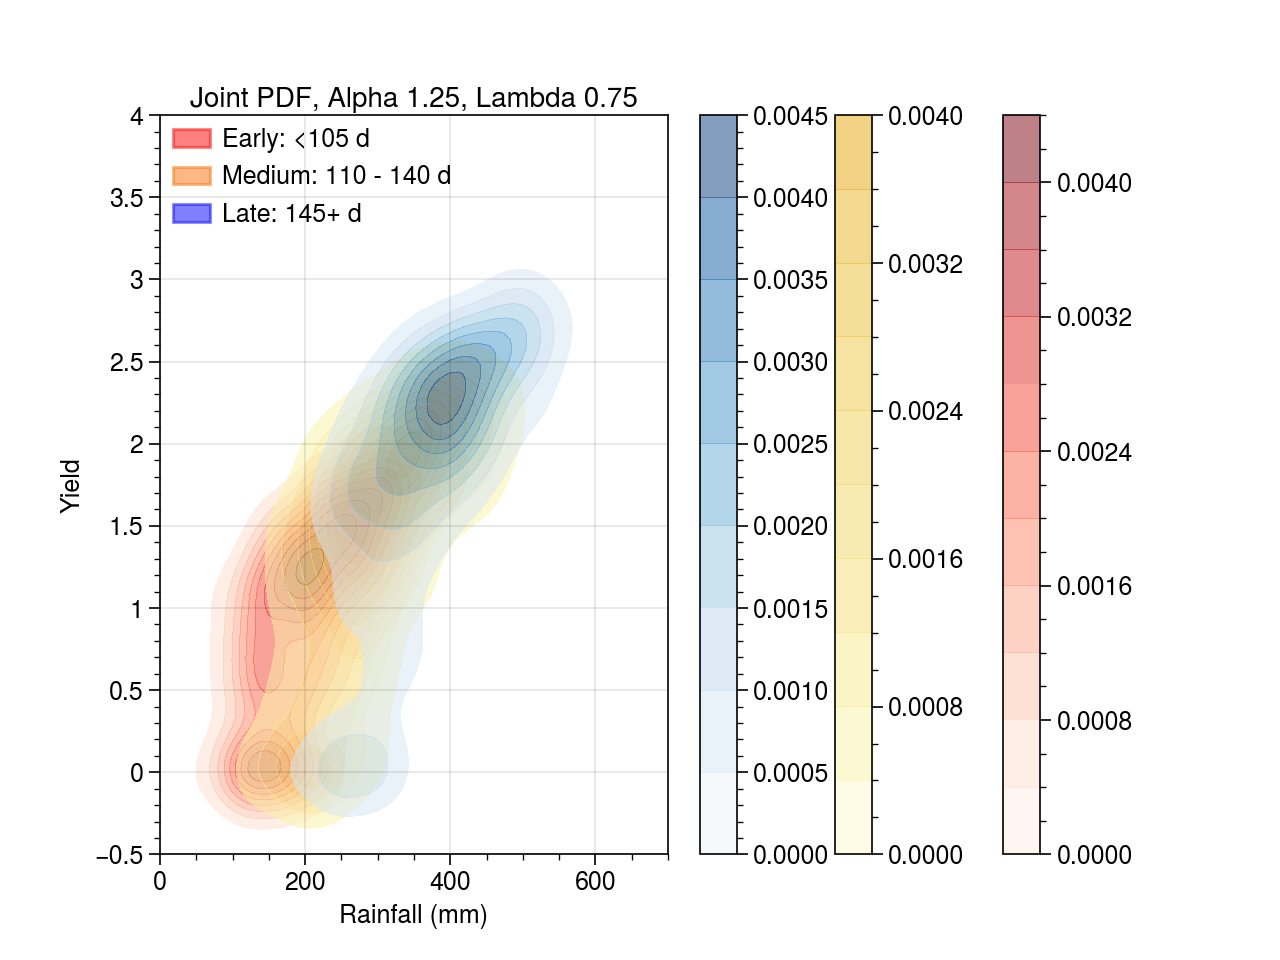

In [139]:
# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

#plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')


########## Plot 2
result = result025

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Set up the figure
f, axs = plt.subplots() #3, figsize=(6,10), sharex=True, sharey=True) # figsize=(15, 15)
#ax.set_aspect("equal")

# Draw the two density plots
axs = sns.kdeplot(early.RF, early.Yield, alpha=0.5,
                 cmap="reds", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
                 cmap="orange1", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
                 cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
plt.title('Joint PDF, Alpha 1.25, Lambda 0.75')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(-.5,4)
plt.xlim(0,700)

(0.0, 700.0)

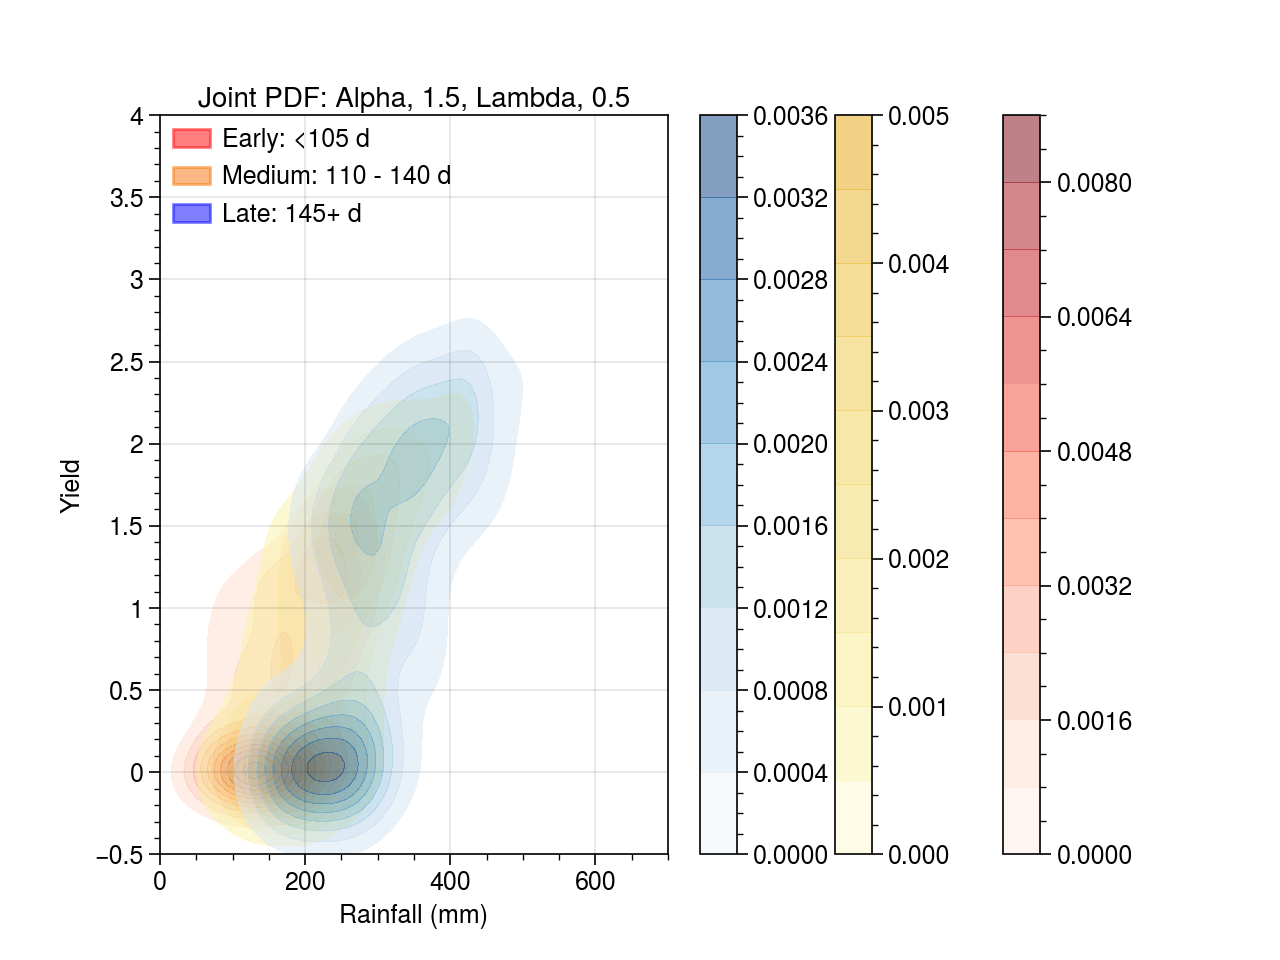

In [146]:
########## Plot 3
result = result05

#plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Draw the two density plots
axs = sns.kdeplot(early.RF, early.Yield, alpha=0.5,
                 cmap="reds", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
                 cmap="orange1", shade=True, shade_lowest=False, cbar=True)
axs = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
                 cmap="blues", shade=True, shade_lowest=False, cbar=True) #greens

# Add labels to the plot
red = sns.color_palette("reds")[-2] #greens
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
#ax.text(350,.5, "early", size=16, color=red)
#ax.text(550,2,"medium",size=16,color=yellow)
#ax.text(680, 3.3, "late", size=16, color=blue)

plt.xlabel('Rainfall (mm)')
plt.title('Joint PDF: Alpha, 1.5, Lambda, 0.5')

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Early: <105 d', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Medium: 110 - 140 d', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Late: 145+ d', alpha=0.5)
plt.legend(handles=[red_patch, orange_patch, blue_patch],loc='upper left', frameon=False) #,  bbox_to_anchor=(0.9, 0.9)
plt.ylim(-.5,4)
plt.xlim(0,700)
#plt.legend(['Early (<105 d)', 'Medium (110 - 140 d)', 'Late (145+ d)'])

### Notes to self about climate alterations

Lambda: probability of rainfall for each month by dividing the number of rainy days per month by the total number of observations in each month.
- So a lambda of 0.10 which is 1/10 means it rains once every 10 days. 

Lambda does change by season, and what we do is increase or decrease the lambda by the same amount each season. Could maybe do this more sophisticated but for now it’s fine. 

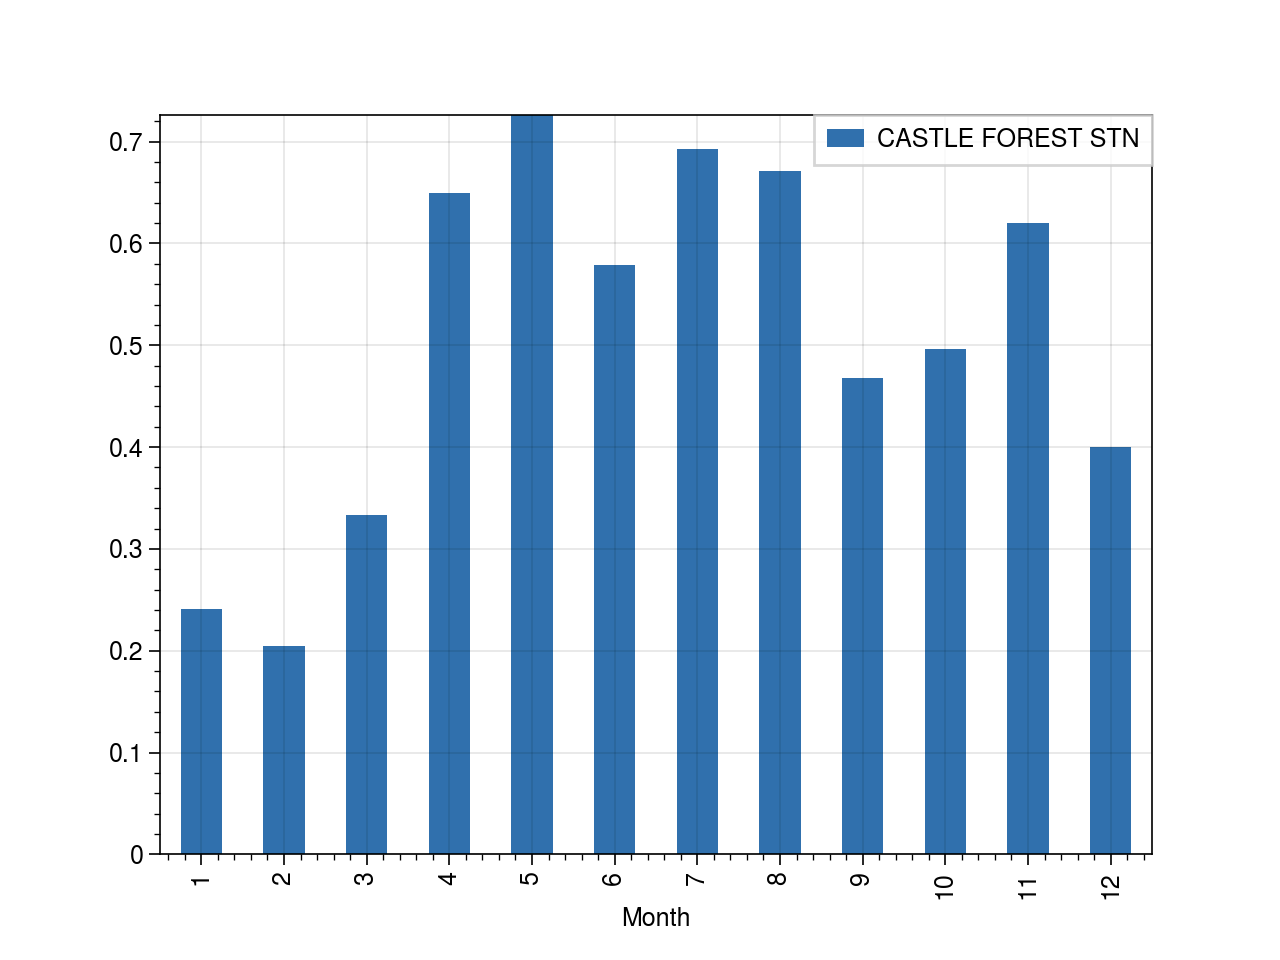

How lambda is changing over time:

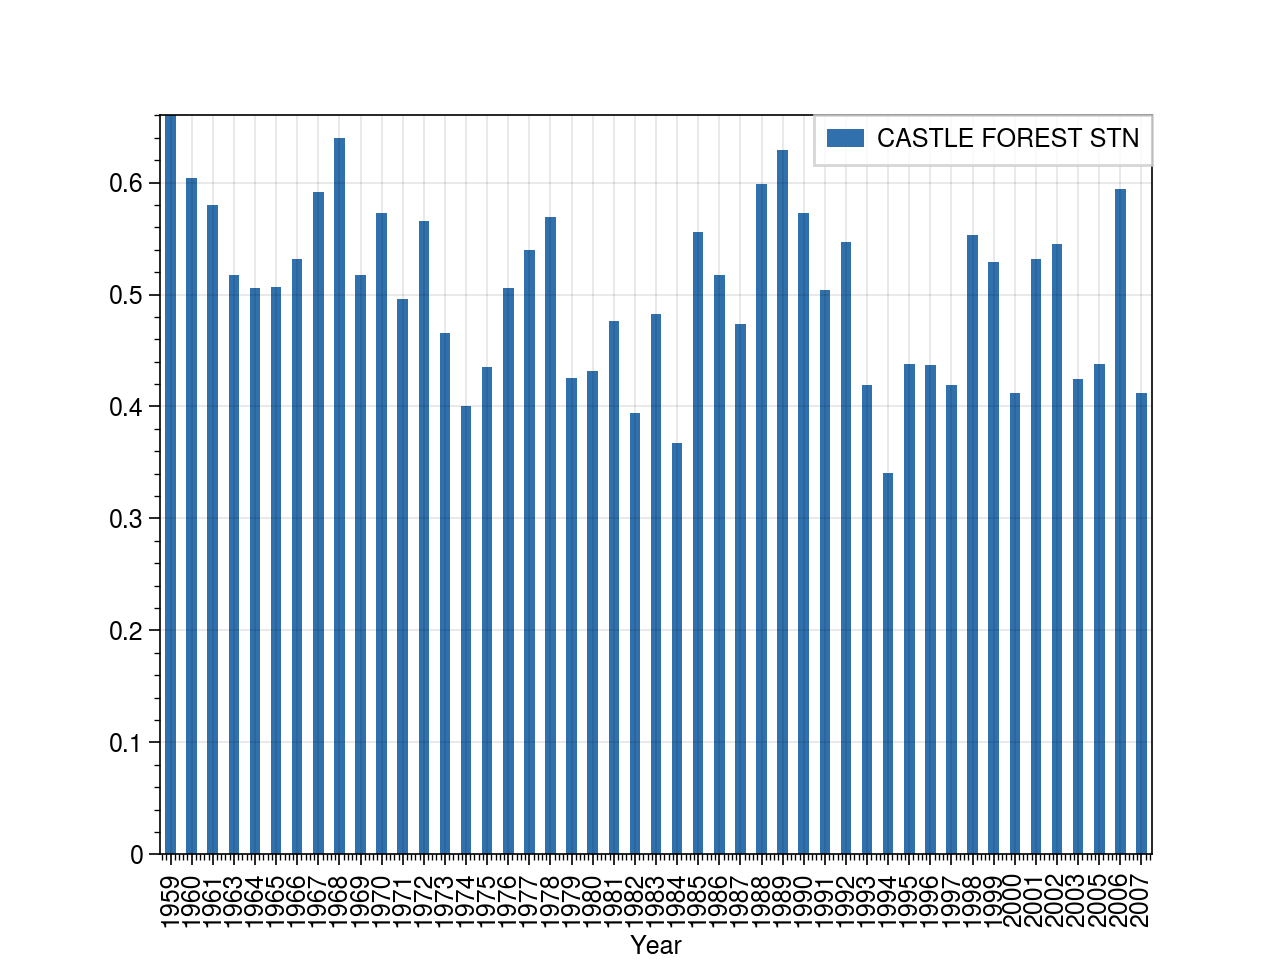

Take the average of the first 3-5 years of the record and compared that to the last 3-5 years of the record. Want them to have similar variances. The number of x years selected is determined by having similar variances.


## Functions I don't need

In [ ]:
# altered rainfall

def check_exponential(data):

	""" Defines function that fits daily rainfall amounts to an exponential distribution and returns pdf 
		and r2. The r2 should be above 0.9 to be an exponential.

		Usage:

			check_exponential(data):

				returns r2, pdf

		How it works:
		- Step 1: To fit the distribution, we use functions from python's suite of numerical analysis, scipy.
		The scipy.stats module has a large suite of distribution functions pre-defined, which we can use to 
		develop a fit for our data. The distribution we are interested in is the exponential distribution, 
		which is called expon in the stats module.

		- Step 2-4: Calculate fitted PDF and error with fit in distribution. To test the fit of our distribution, 
		we can compare the empirical histogram to that predicted by our model. We first use our `data` to generate 
		the empirical histogram. In this example, we break the data into `30` bins, and we generate a histrogram 
		of `density` rather than counts. This allows for an easier comparison between our empirical data and the 
		fitted probability distribution function. 
		
		Here are the steps:

		1. Generate a histogram, from the `data`. Save the bin locations in `x` and the density of values in `y`
		2. Shift the `x` bin locations generated from the histogram to the center of bins.
		3. Calculate the value of the fitted `pdf(x)` for each of the bins in `x`.
		4. Determine the residual sum of the squares, $SS_{error}$, and total sum of squares, $SS_{yy}$, according 
		to the equations in rainfall-variability.ipynb.
	"""

	# Step 1. Fit the distribution.
	distribution = st.expon
	params = distribution.fit(data, loc=0) # Force the distribution to be built off of zero

	arg = params[:-2]
	loc = params[-2]
	scale = params[-1]

	y, x = np.histogram(data, bins=30, density=True)

	# Step 2. Shift the x bin locations to the center of bins.
	x = (x + np.roll(x, -1))[:-1] / 2.0

	# Step 3. Calculate the values of pdx(x) for all x.
	pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

	# Step 4. Determine the residual and total sum of the squares.
	ss_error = np.sum(np.power(y - pdf, 2.0))
	ss_yy = np.sum(np.power(y - y.mean(), 2.0))

	r_2 = 1 - ( ss_error / ss_yy )

	if r_2 < 0.9:
		print("WARNING. r2 for {station} is {r_2}".format(
			station=station,
			r_2=r_2))

	return r_2, pdf


def make_climate_parameters(station='OL JOGI FARM'):

	# Prepare the CETRAD dataset.
	year_min = 30 # minimum number of years to consider for a valid climate record.

	df = pd.read_csv("../data/CETRAD/CETRAD_rainfall.csv")  # Read in the raw csv data.

	# Step 1. Convert text strings into datetime objects.
	format = '%m/%d/%y' # Column RDate has data in M/D/YY
	df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

	# 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
	# Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
	# We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
	# their value. This requires using the relativedelta function, which handles weird stuff like leap years.
	df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

	# Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
	df['Year'] = [dt.year for dt in df['Datetime']]
	df['Month'] = [dt.month for dt in df['Datetime']]

	n_years = len(df['Year'].unique())

	# Check to make sure we have enough data for fitting and parameter estimation.
	if n_years < year_min:
		print("WARNING! Station record for {station} has only {n_years} years.".format(
			station=station,
			n_years=n_years))

	# Step 4. Use the Datetime values as the index for this dataframe.
	df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

	# Step 5.  Delete the old RDate column, which we no longer need. 
	# We will keep the Datetime column, in case we need it later.
	df = df.drop(['RDate'], axis=1)

	columns = [station] + ['Year', 'Month', 'Datetime']
	rainfall = df[columns]

	# First, find all the rows in the data where it rained and group by month.
	rain_days = rainfall.loc[rainfall[station] > 0]

	# Find all locations in the data where an observation was made.
	all_days = rainfall.loc[rainfall[station] >= 0]

	# Find just the rainfall amounts on days that it rained.
	data = rainfall.loc[rainfall[station] > 0][station]
	
	# Fit the daily rainfall amounts to an exponential distribution.
	check_exponential(data)

	# Determine the Monthly values of alpha and lambda from the station data:
	lambda_by_month = (
	    rain_days.groupby('Month')[station].count() /
	    all_days.groupby('Month')[station].count()
	)

	alpha_by_month = rain_days.groupby('Month')[station].mean()

	# MAKE THE CLIMATE PARAMETER DICT:
	climate = pd.DataFrame(alpha_by_month)
	climate = climate.rename(columns={station: 'alpha_by_month'})
	climate['lambda_by_month'] = lambda_by_month

	return climate['alpha_by_month'].to_list(), climate['lambda_by_month'].to_list(), rainfall

@functools.lru_cache(maxsize=128)
def average_soil_moisture(model, n_sims=100, t_before=60, doy=None):

	alpha_r = model.climate.alpha_r
	lambda_r = model.climate.lambda_r
	climates = [Climate(alpha_r, lambda_r) for sim in np.arange(n_sims)]
    
	# Create a temporary crop object with a 0 day length of growing period.
	temp_crop = copy.copy(model.crop)
	temp_crop.lgp = 0

    # Get output from each simulataion using an implicit for loop.
	# Use the temp crop object to create these models.
	models = [ CropModel(crop=temp_crop,soil=model.soil,climate=climates[i]) for i in np.arange(n_sims) ]
	
	output = [ models[i].run(do_output=True, planting_date=doy+1, t_before=t_before, t_after=0) for i in np.arange(n_sims) ]

    # Extract the final value of soil moisture from each output.
	values = pd.DataFrame([output[i]['s'][-1:] for i in np.arange(n_sims)])
	return values.mean(), values.std()